## 方針
20000以上のyを削除  
50000以上のAreaを削除

## 結果
LB: 67.507  
RMSE: 132.08384162013186
```
count    34844.000000
mean        63.907809
std        157.396457
min          0.000000
25%         23.890000
50%         36.900000
75%         54.680000
max       6780.890000
Name: y, dtype: float64
```
yが大きい数値をうまく予測できていない

train_low = train.query('(MunicipalityCode < 13150 and Area < 600) or MunicipalityCode > 13150')の時  
```
[5000]	training's mape: 0.310165	valid_1's mape: 0.333322
Did not meet early stopping. Best iteration is:
[5000]	training's mape: 0.310165	valid_1's mape: 0.333322
87241 87241 87241
RMSE: 73.16353686070322
```
Areaもうまく調節すればCVもLBも上がるかもしれない

In [56]:
import pandas as pd
import numpy as np
import json
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import sklearn
print('sklearn version:', sklearn.__version__)
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import Pool

import warnings
warnings.filterwarnings('ignore')

lightgbm version: 2.3.0
sklearn version: 0.22.1


In [2]:
train = pd.read_csv('../data/raw/train_data.csv')
test = pd.read_csv('../data/raw/test_data.csv')

In [3]:
# ↑のjsonファイルをnames.jsonで保存してある前提
with open("columns.json", "r", encoding="utf-8") as f:
     d = json.load(f)
        
train = train.rename(columns=d)
test = test.rename(columns=d)        

In [4]:
pub = pd.read_csv('../data/raw/published_land_price.csv')

In [5]:
pair = {"所在地コード":"市区町村コード","建蔽率":"建ぺい率（％）","容積率":"容積率（％）","駅名":"最寄駅：名称", 
        "地積":"面積（㎡）","市区町村名":"市区町村名",'前面道路の幅員':'前面道路：幅員（ｍ）', 
        "前面道路の方位区分":"前面道路：方位","前面道路区分":"前面道路：種類","形状区分":"土地の形状",
        "用途区分":"都市計画"
         }
pub = pub.rename(columns=pair)
pub = pub.rename(columns=d)

## 不要なカラムを落とす 

In [6]:
delete_columns = ['id', 'Prefecture', 'Municipality', 'DistrictName']
train = train.drop(delete_columns, axis=1)
test = test.drop(delete_columns, axis=1)

In [7]:
train = train.drop_duplicates()

### yが20000の列を削除

In [8]:
train.query('y >= 18000').index
train = train.drop(train.query('y >= 18000').index, axis=0)

In [9]:
y = train['y']
train = train.drop('y', axis=1)

In [10]:
data = pd.concat([train, test])

## stationの整形

In [11]:
Near = data['NearestStation'].str.split('(', expand=True)
data = data.drop('NearestStation', axis=1)
data['NearestStation'] = Near[0]

In [12]:
def get_mean(search, cat):
        leng = search.shape[0]
        sum = 0
        for i in range(leng):
            if search.iloc[i][cat] != 0:
                sum += search.iloc[i][cat]
        return sum/leng

In [13]:
new_columns = ['latitude', 'longitude','h31_price', 'h30_price', 'h29_price', 'h28_price', 'h27_price']

data['NearestStation+MunicipalityCode'] = data['NearestStation'] + '+' + data['MunicipalityCode'].astype(str)

for i in new_columns:
    data[i] =data['NearestStation+MunicipalityCode']

def get_mean(search, cat):
        leng = search.shape[0]
        sum = 0
        for i in range(leng):
            if search.iloc[i][cat] != 0:
                sum += search.iloc[i][cat]
        return sum/leng

for i in tqdm(data['NearestStation+MunicipalityCode'].unique()):
    try:
            ns, mc = i.split('+')
            search = pub[pub['MunicipalityCode'] == int(mc)][pub['NearestStation'] == ns]
            try:
                data['latitude'] = data['latitude'].replace(i, get_mean(search, '緯度'))
                data['longitude'] = data['longitude'].replace(i, get_mean(search, '経度'))
                data['h31_price'] = data['h31_price'].replace(i, get_mean(search, 'Ｈ３１価格'))
                data['h30_price'] = data['h30_price'].replace(i, get_mean(search, 'Ｈ３０価格'))
                data['h29_price'] = data['h29_price'].replace(i, get_mean(search, 'Ｈ２９価格'))
                data['h28_price'] = data['h28_price'].replace(i, get_mean(search, 'Ｈ２８価格'))
                data['h27_price'] = data['h27_price'].replace(i, get_mean(search, 'Ｈ２７価格'))
            except:
                try:
                    search = pub[pub['NearestStation'] == ns]
                    data['latitude'] = data['latitude'].replace(i, get_mean(search, '緯度'))
                    data['longitude'] = data['longitude'].replace(i, get_mean(search, '経度'))
                    data['h31_price'] = data['h31_price'].replace(i, get_mean(search, 'Ｈ３１価格'))
                    data['h30_price'] = data['h30_price'].replace(i, get_mean(search, 'Ｈ３０価格'))
                    data['h29_price'] = data['h29_price'].replace(i, get_mean(search, 'Ｈ２９価格'))
                    data['h28_price'] = data['h28_price'].replace(i, get_mean(search, 'Ｈ２８価格'))
                    data['h27_price'] = data['h27_price'].replace(i, get_mean(search, 'Ｈ２７価格'))                                    
                except:
                    data['latitude'] = data['latitude'].replace(i, np.nan)
                    data['longitude'] = data['longitude'].replace(i, np.nan)
                    data['h31_price'] = data['h31_price'].replace(i, np.nan) 
                    data['h30_price'] = data['h30_price'].replace(i, np.nan)
                    data['h29_price'] = data['h29_price'].replace(i, np.nan)
                    data['h28_price'] = data['h28_price'].replace(i, np.nan)
                    data['h27_price'] = data['h27_price'].replace(i, np.nan)                                 
    except:
            continue

/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [14]:
data = data.drop('NearestStation+MunicipalityCode', axis=1)

In [15]:
data['h31_price'] = data['h31_price'].replace(0, np.nan) 
data['h30_price'] = data['h30_price'].replace(0, np.nan)
data['h29_price'] = data['h29_price'].replace(0, np.nan)
data['h28_price'] = data['h28_price'].replace(0, np.nan)
data['h27_price'] = data['h27_price'].replace(0, np.nan) 

In [16]:
price_df = pd.DataFrame({'h31_price': data['h31_price'].values, 'h30_price': data['h30_price'].values, 
                         'h29_price': data['h29_price'].values, 'h28_price': data['h28_price'].values, 
                              'h27_price' : data['h27_price'].values})

In [17]:
price_df['h31_27_mean'] = price_df.mean(axis='columns')
price_df['31-28'] = price_df['h31_price'] - price_df['h28_price']
data = data.drop(['h30_price', 'h29_price', 'h28_price', 'h27_price'], axis=1)
data['h31_27_mean'] = price_df['h31_27_mean']
data['31-28'] = price_df['31-28']

## building_id

In [18]:
data['building_id'] = data.groupby(['MunicipalityCode', 'TimeToNearestStation','BuildingYear', 'Structure', 'Use', 'NearestStation', 'FloorPlan']
                              ).grouper.group_info[0]


## 数値データの整形

In [19]:
def calc_mean_median(df, df_type):
    dumy = df
    dumy = dumy.dropna()
    dumy = dumy.astype(df_type)
    df = df.fillna(dumy.mean())
    df = df.astype(df_type)
    return df

### 最寄駅：距離（分） 

In [20]:
data['TimeToNearestStation'] = data['TimeToNearestStation'].replace('2H?', '120').replace('30分?60分', '45'). \
        replace('1H30?2H', '105').replace('1H?1H30', '75')

In [21]:
data['TimeToNearestStation'] = calc_mean_median(data['TimeToNearestStation'], np.int64)

### 面積

In [22]:
dumy_area = data['Area'].replace('2000㎡以上', np.nan).replace('5000㎡以上', np.nan)
dumy_area = dumy_area.dropna()
dumy_area = dumy_area.astype(np.int64)
# 2000以上5000以下の平均値を取得
area_mean_2000_5000 = np.median([i for i in dumy_area if i > 2000 and i < 5000])
# 5000以上はないので5500で置換
# 欠損値を埋めるための平均と中央値
dim_mean = dumy_area.mean()
dim_median = dumy_area.median()

In [23]:
data['Area'] = data['Area'].replace('2000㎡以上',  area_mean_2000_5000).replace('5000㎡以上', np.nan)
data['Area'] =  data['Area'].fillna(dim_mean)  
data['Area'] = data['Area'].astype(np.int64)

### 間口

In [24]:
data['Frontage'] = data['Frontage'].replace('50.0m以上', '60.0')

In [25]:
data['Frontage'] =   calc_mean_median(data['Frontage'], np.float32)

### 延床面積（㎡）

In [26]:
data['TotalFloorArea'] = data['TotalFloorArea'].replace('2000㎡以上', '2500').replace( '10m^2未満', '5')

In [27]:
data['TotalFloorArea'] =  calc_mean_median(data['TotalFloorArea'], np.int64)

### 築年数

In [28]:
tiku_columns = ['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '戦前', '平成29年', '昭和36年',
       '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年', '平成30年',
       '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年', '昭和33年',
       '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年', '昭和22年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年']

for i in tiku_columns:
    if '平成' in i:
        year = int(i.replace('年', '').replace('平成', '')) +2000-12
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
    if '昭和' in i:
        year = int(i.replace('年', '').replace('昭和', '')) + 1925
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
        

In [29]:
data['BuildingYear'].unique()

array([1984, 2003, 2012, 1986, 1999, 1985, 2007, 1998, nan, 1982, 1970,
       1972, 1968, 1989, 2013, 2004, 1997, 1993, 1976, 2001, 1977, 1980,
       1979, 1990, 2009, 2010, 2006, 2002, 1994, 2005, 1987, 2000, 1963,
       1966, 1973, 2008, 1978, 1974, 2014, 1983, 1981, 1960, 1975, 1962,
       2011, 1995, 1991, 1988, '戦前', 2017, 1961, 2016, 1964, 1992, 2015,
       1967, 1956, 2018, 1969, 1954, 1996, 1952, 1971, 1955, 1958, 1957,
       1965, 1951, 1959, 1950, 1953, 1947, 1949, 1948, 1946, 2019],
      dtype=object)

In [30]:
data['BuildingYear'] = data['BuildingYear'].replace('戦前', 1960)

In [31]:
data['BuildingYear'] =  calc_mean_median(data['BuildingYear'], np.int64)

In [32]:
data['BuildingYear'] = data['BuildingYear'] -1900

## 前面道路：幅員（ｍ）

In [33]:
data['Breadth']=  calc_mean_median(data['Breadth'], np.float64)

###  建ぺい率（％) 容積率（％） 

In [34]:
data['CoverageRatio']=  calc_mean_median(data['CoverageRatio'], np.float64)
data['FloorAreaRatio']=  calc_mean_median(data['FloorAreaRatio'], np.float64)

### 取引時点

In [35]:
torihiki_columns = data['Period'].unique()

In [36]:
for i, value in enumerate(sorted(torihiki_columns)):
    data['Period'] =  data['Period'].replace(value, i)

## カテゴリーデータの整形

### 最寄駅：名称 - labelエンコード

In [37]:
# data['L'] = data['FloorPlan'].map(lambda x: 1 if 'Ｌ' in str(x) else 0)
# data['D'] = data['FloorPlan'].map(lambda x: 1 if 'Ｄ' in str(x) else 0)
# data['K'] = data['FloorPlan'].map(lambda x: 1 if 'Ｋ' in str(x) else 0)
# data['S'] = data['FloorPlan'].map(lambda x: 1 if 'Ｓ' in str(x) else 0)
# data['R'] = data['FloorPlan'].map(lambda x: 1 if 'Ｒ' in str(x) else 0)
# data['Maisonette'] = data['FloorPlan'].map(lambda x: 1 if 'メゾネット' in str(x) else 0)
# data['OpenFloor'] = data['FloorPlan'].map(lambda x: 1 if 'オープンフロア' in str(x) else 0)
# data['Studio'] = data['FloorPlan'].map(lambda x: 1 if 'スタジオ' in str(x) else 0)

### 用途

In [38]:
use_dummy =data['Use'].fillna('missing')
use_dummy=  use_dummy.str.replace('共同住宅', '共同')
for i in use_dummy.unique():
    new_use = ''
    if '住宅' in i:
        new_use += '1'
    else:
        new_use += '0'
    new_use += ','
    if '事務所' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '店舗' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if 'その他' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '倉庫' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '駐車場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '工場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '共同' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '作業場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    use_dummy = use_dummy.replace(i, new_use)

In [39]:
data_use = use_dummy.str.split(',', expand=True)

In [40]:
use_columns={0: 'Housing', 1: 'office', 2: 'store', 3: 'other_use', 4: 'Warehouse', 5: 'parking', 6: 'plant', 7: 'shareHouse', 8: 'Workshop'}
data_use = data_use.rename(columns=use_columns)

In [41]:
for i in data_use.columns:
    data_use[i] = data_use[i].astype(np.int64)

In [42]:
for i in data_use.columns:
    data[i] = data_use[i]

## ラベルエンコーディング

In [43]:
categorical_features = ['Type', 'Region', 'NearestStation', 'FloorPlan','LandShape', 'Structure', 'Use', 'Purpose', 'Direction', \
         'Classification', 'CityPlanning', 'Renovation', 'Remarks']

In [44]:
for c in categorical_features:
    data[c] =  data[c].fillna('missing') 

In [45]:
from sklearn.preprocessing import LabelEncoder

for c in categorical_features:
    le = LabelEncoder()
    le.fit(data[c])
    data[c] = le.transform(data[c])

## 値の微調整

In [46]:
data['longitude'] = data['longitude'] - 500000

In [47]:
data['latitude'] = data['latitude'] -120000

In [48]:
price_cols = ['h31_price', 'h31_27_mean']   
for i in price_cols:
    data[i] = data[i] /10000

## 市域コード別に平均と最大を計算


In [49]:
city_mean_colums = ['MunicipalityCode', 'Area', 'LandShape', 'Frontage', 'BuildingYear',
                           'TotalFloorArea', 'h31_price', 'Breadth', 'Structure', 'FloorAreaRatio']

data_city_mean =  data[city_mean_colums].groupby('MunicipalityCode').mean()

for i in city_mean_colums:
    if i != 'MunicipalityCode':
        data['citycode_mean_' + i] = data['MunicipalityCode']
        for j, value in enumerate(data['MunicipalityCode'].unique()):
            data['citycode_mean_' + i] = data['citycode_mean_' + i].replace(value, data_city_mean[i].iloc[j])

In [50]:
data_city_max =  data[city_mean_colums].groupby('MunicipalityCode').max()

for i in city_mean_colums:
    if i != 'MunicipalityCode':
        data['citycode_max_' + i] = data['MunicipalityCode']
        for j, value in enumerate(data['MunicipalityCode'].unique()):
            data['citycode_max_' + i] = data['citycode_max_' + i].replace(value, data_city_mean[i].iloc[j])

In [51]:
period_mean_colums = ['Period', 'Area', 'LandShape', 'Frontage', 'BuildingYear',
                           'TotalFloorArea', 'h31_price', 'Breadth', 'Structure', 'FloorAreaRatio', 'longitude']

data_period_mean =  data[period_mean_colums].groupby('Period').mean()

for i in period_mean_colums:
    if i != 'Period':
        data['period_mean_' + i] = data['Period']
        for j, value in enumerate(data['Period'].unique()):
            data['period_mean_' + i] = data['period_mean_' + i].replace(value, data_period_mean[i].iloc[j])
            
data_period_max =  data[period_mean_colums].groupby('Period').max()

for i in period_mean_colums:
    if i != 'Period':
        data['period_max_' + i] = data['Period']
        for j, value in enumerate(data['Period'].unique()):
            data['period_max_' + i] = data['period_max_' + i].replace(value, data_period_max[i].iloc[j])        

In [52]:
data['TimeToNearestStation_NearestStation'] = data['NearestStation'] * data['TimeToNearestStation']
data['h31_27_mean_office'] = data['office'] * data['h31_27_mean']
data['h31_27_mean_ostore'] = data['store'] * data['h31_27_mean']
data['office_and_store'] = data['office'] * data['store']

In [53]:
drop_columns = ['citycode_max_Structure', 'building_id', 'FloorPlan', 'plant',
       'period_max_Structure', 'period_max_LandShape',
       'period_max_Frontage', 'period_max_TotalFloorArea',
       'period_max_longitude']

data = data.drop(drop_columns, axis=1)

In [54]:
train = data[:len(train)]
test = data[len(train):]

## 学習

In [57]:
scores = []
y_pred = np.zeros(test.shape[0])
kf = KFold(n_splits=5, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train):
    tr_x, va_x = train.iloc[tr_idx], train.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
    
    train_pool = Pool(tr_x, label=tr_y)
    test_pool = Pool(va_x, label=va_y)

    params = {
            'loss_function': 'MAPE',
            'iterations': 10000,
            'od_type': "Iter",
            'depth': 10,
            'colsample_bylevel': 0.5,
            'early_stopping_rounds': 300,
            'l2_leaf_reg': 18,
            'random_seed': 42,
            'use_best_model': True
    }


    model =  CatBoostRegressor(**params)
    model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=200,              
    )

    y_val_pred = model.predict(va_x)
    val_score = np.sqrt(mean_squared_error(va_y, y_val_pred))
    y_pred  += model.predict(test)
    scores.append(val_score)

print('RMSE:', np.mean(scores))

0:	learn: 0.6481557	test: 0.6560929	best: 0.6560929 (0)	total: 166ms	remaining: 27m 41s
200:	learn: 0.3646357	test: 0.3708367	best: 0.3708367 (200)	total: 15.8s	remaining: 12m 51s
400:	learn: 0.3237615	test: 0.3308313	best: 0.3308313 (400)	total: 32.6s	remaining: 12m 59s
600:	learn: 0.3046985	test: 0.3127838	best: 0.3127838 (600)	total: 49.7s	remaining: 12m 57s
800:	learn: 0.2934345	test: 0.3024431	best: 0.3024431 (800)	total: 1m 7s	remaining: 12m 59s
1000:	learn: 0.2857535	test: 0.2958512	best: 0.2958512 (1000)	total: 1m 24s	remaining: 12m 43s
1200:	learn: 0.2806137	test: 0.2916254	best: 0.2916254 (1200)	total: 1m 42s	remaining: 12m 34s
1400:	learn: 0.2765825	test: 0.2883785	best: 0.2883785 (1400)	total: 2m	remaining: 12m 20s
1600:	learn: 0.2726558	test: 0.2854643	best: 0.2854643 (1600)	total: 2m 18s	remaining: 12m 5s
1800:	learn: 0.2698545	test: 0.2833412	best: 0.2833412 (1800)	total: 2m 35s	remaining: 11m 46s
2000:	learn: 0.2672827	test: 0.2814236	best: 0.2814236 (2000)	total: 2m 51

2600:	learn: 0.2648544	test: 0.2751649	best: 0.2736649 (2579)	total: 3m 38s	remaining: 10m 21s
2800:	learn: 0.2632828	test: 0.2741092	best: 0.2736649 (2579)	total: 3m 55s	remaining: 10m 5s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2736648748
bestIteration = 2579

Shrink model to first 2580 iterations.
0:	learn: 0.6496801	test: 0.6502357	best: 0.6502357 (0)	total: 86.6ms	remaining: 14m 25s
200:	learn: 0.3664579	test: 0.3671274	best: 0.3671274 (200)	total: 16.1s	remaining: 13m 3s
400:	learn: 0.3267689	test: 0.3283769	best: 0.3283769 (400)	total: 32.2s	remaining: 12m 50s
600:	learn: 0.3081146	test: 0.3105770	best: 0.3105770 (600)	total: 48.4s	remaining: 12m 37s
800:	learn: 0.2972867	test: 0.3007268	best: 0.3007268 (800)	total: 1m 5s	remaining: 12m 32s
1000:	learn: 0.2906212	test: 0.2949653	best: 0.2949653 (1000)	total: 1m 22s	remaining: 12m 22s
1200:	learn: 0.2850010	test: 0.2902488	best: 0.2902488 (1200)	total: 1m 39s	remaining: 12m 11s
1400:	learn: 0.2805155	t

8800:	learn: 0.2447784	test: 0.2701609	best: 0.2699730 (8656)	total: 12m 35s	remaining: 1m 42s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2699729758
bestIteration = 8656

Shrink model to first 8657 iterations.
RMSE: 207.9533082117247


In [59]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
feature_importances['importance'] = model.get_feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
4,Area,25.586898
8,BuildingYear,17.319798
24,h31_price,5.320050
13,Classification,5.281629
15,CityPlanning,4.229712
...,...,...
31,Warehouse,0.000000
32,parking,0.000000
33,shareHouse,0.000000
34,Workshop,0.000000


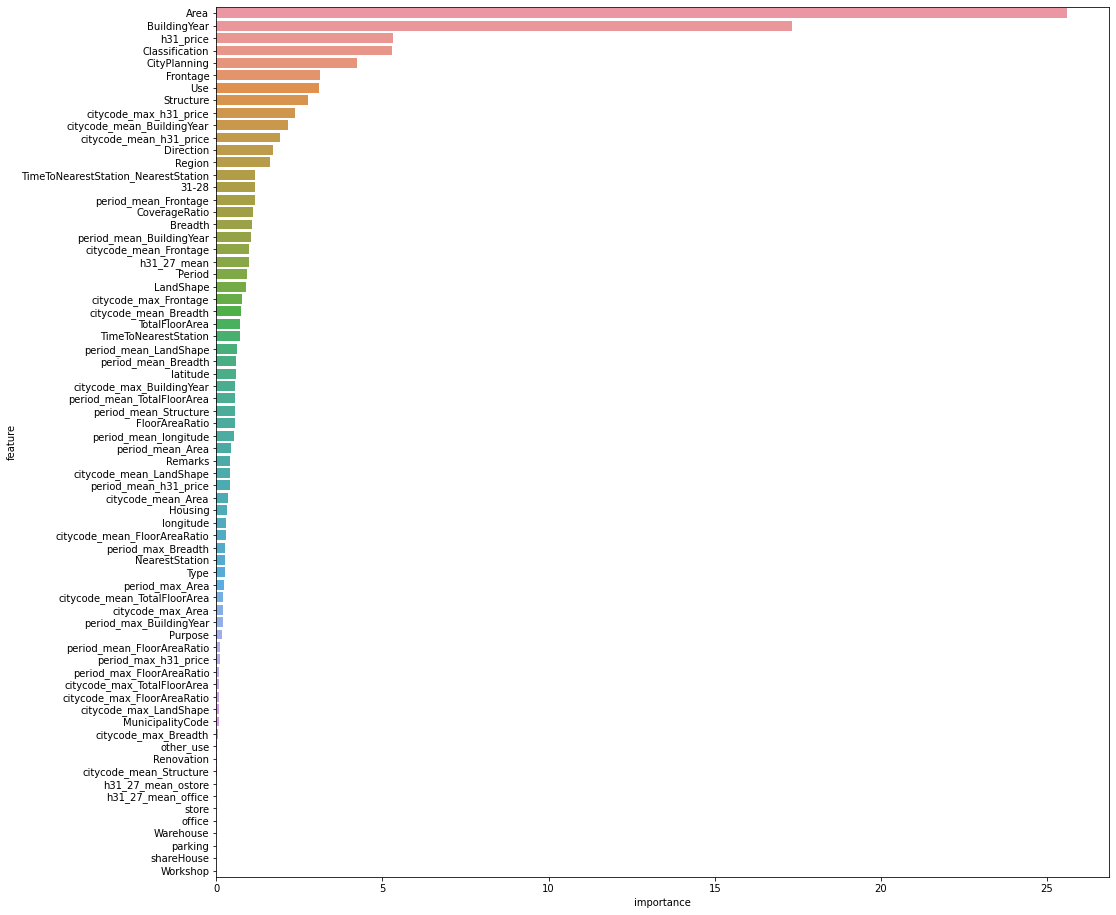

In [60]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(70), x='importance', y='feature')

In [61]:
y_pred_fi = y_pred /4
y_pred_fi = np.round(y_pred_fi, 2)

In [62]:
submit = pd.read_csv('../data/raw/test_data.csv')

In [63]:
sub = pd.DataFrame({'id': submit['id'], 'y': y_pred_fi})

In [64]:
sub['y'].describe()

count    34844.000000
mean        55.246206
std         58.677390
min         -4.280000
25%         27.950000
50%         43.670000
75%         63.802500
max       2198.420000
Name: y, dtype: float64

In [65]:
sub.query('y < 0.001')

,id,y
34070,34071,-4.28


In [66]:
for i in sub[sub['y'] < 0]['id']:
    sub['y'][i-1] = 0 

In [67]:
sub.to_csv('sub_catboost_6.csv', index=False)

In [68]:
sub['y'].describe()

count    34844.000000
mean        55.246329
std         58.677270
min          0.000000
25%         27.950000
50%         43.670000
75%         63.802500
max       2198.420000
Name: y, dtype: float64